In [1]:
import numpy as np
import tensorflow as tf


from tensorflow import keras
from tensorflow.keras import layers

## Create Simulated Data

In [2]:
def create_data(n=100):
    """
        f(x1, x2) = 5 * x_1**2 + 4 * x_2**2 - 3 * x_1 * x_2
    """
    ret = np.zeros(shape=(n, 3)).astype("float32")
    x = np.random.rand(n, 2)
    y = (5 * x[:, 0]**2 + 4 * x[:, 1]**2 - 3 * x[:, 0] * x[:, 1]).reshape(-1, 1)
    ret[:, [0, 1]] = x
    ret[:, [2]] = y
    
    return ret

## Test Out Function

In [3]:
d = create_data(4)

In [4]:
d

array([[0.96870315, 0.6142369 , 4.416037  ],
       [0.97649235, 0.84224004, 5.1378365 ],
       [0.11048811, 0.72640204, 1.9309014 ],
       [0.9964829 , 0.2919001 , 4.433093  ]], dtype=float32)

In [5]:
val = round(5 * d[0, 0]**2 + 4 * d[0, 1]**2 - 3 * d[0, 0] * d[0, 1], 4)
exp_val = round(d[0, 2], 4)

val, exp_val

(4.416, 4.416)

## Create Network

The network that we will create will have two dense layers with ReLU activations. The goal is to see how many of these neurons become "dead".

### Train and Test Data

In [6]:
NUM_SAMPLES = 5000
TRAIN_FRAC = 0.60
VAL_FRAC = 0.20

data = create_data(n=NUM_SAMPLES)

train_idx = int(TRAIN_FRAC * NUM_SAMPLES)
val_idx = train_idx + int(VAL_FRAC * NUM_SAMPLES)

train_data = data[: train_idx]
val_data = data[train_idx: val_idx]
test_data = data[val_idx: ]

### Normalizer 

In [7]:
def normalize(data: np.array, mean: np.array=None, sd: np.array=None):
    if (mean is not None) and (sd is not None):
        assert data.shape[1] == len(mean) == len(sd)
    
    if mean is None:
        mean = data.mean(axis=0)
    if sd is None:
        sd = data.std(axis=0)
    
    normed = (data - mean) / sd
    
    return mean, sd, normed

In [8]:
mean, sd, norm_train_data = normalize(train_data)
_, _, norm_val_data = normalize(val_data, mean=mean, sd=sd)
_, _, norm_test_data = normalize(test_data, mean=mean, sd=sd)

### Model Layers

In [9]:
NUM_UNITS = 3

inputs = keras.Input(shape=2)

dense_1 = layers.Dense(units=NUM_UNITS, activation='relu')(inputs)
# leaky_1 = tf.keras.layers.LeakyReLU(dense_1)

dense_2 = layers.Dense(units=NUM_UNITS, activation='relu')(dense_1)
# leaky_2 = tf.keras.layers.LeakyReLU(dense_2) 

output = layers.Dense(units=1, activation=None)(dense_2)

In [10]:
model = keras.Model(inputs=inputs, outputs=output)
model.compile(optimizer='rmsprop', loss='mean_squared_error')

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 9         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 12        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 4         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback


checkpoint_filepath = './checkpoint'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True)

weights_dict = {}

weight_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: weights_dict.update({epoch: model.get_weights()})
)

In [13]:
BATCH_SIZE = 32
EPOCHS = 30

train_dataset = tf.data.Dataset.from_tensor_slices((test_data[:, [0, 1]], 
                                                    test_data[:, [2]])).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_data[:, [0, 1]], 
                                                  val_data[:, [2]])).batch(BATCH_SIZE)

history = model.fit(train_dataset,
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, 
                    validation_data=val_dataset, 
                    callbacks=[weight_callback])

Epoch 1/30
32/32 [==============================] - 1s 12ms/step - loss: 5.9695 - val_loss: 5.1063
Epoch 2/30
32/32 [==============================] - 0s 2ms/step - loss: 5.2566 - val_loss: 4.4836
Epoch 3/30
32/32 [==============================] - 0s 2ms/step - loss: 4.6062 - val_loss: 3.8699
Epoch 4/30
32/32 [==============================] - 0s 2ms/step - loss: 3.9658 - val_loss: 3.2772
Epoch 5/30
32/32 [==============================] - 0s 2ms/step - loss: 3.3486 - val_loss: 2.7270
Epoch 6/30
32/32 [==============================] - 0s 2ms/step - loss: 2.7757 - val_loss: 2.2416
Epoch 7/30
32/32 [==============================] - 0s 2ms/step - loss: 2.2728 - val_loss: 1.8451
Epoch 8/30
32/32 [==============================] - 0s 2ms/step - loss: 1.8631 - val_loss: 1.5568
Epoch 9/30
32/32 [==============================] - 0s 2ms/step - loss: 1.5675 - val_loss: 1.3855
Epoch 10/30
32/32 [==============================] - 0s 2ms/step - loss: 1.3939 - val_loss: 1.3116
Epoch 11/30
32/32 

In [14]:
pred = model.predict(test_data[:, [0, 1]])

In [15]:
np.mean((pred - test_data[:, [2]])**2)

0.72697914

## Evolution of Weights by Epoch

In [16]:
weights_dict.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [17]:
weights_dict[0]

[array([[ 1.010577  , -0.37773353, -0.27154386],
        [-0.74094945, -0.8402842 , -0.45783675]], dtype=float32),
 array([0.04037941, 0.        , 0.        ], dtype=float32),
 array([[ 0.70961154,  0.28674605, -0.06587219],
        [ 0.5367861 ,  0.03980374,  0.4424007 ],
        [-0.1917727 , -0.60495305, -0.2907281 ]], dtype=float32),
 array([0.04099162, 0.04117266, 0.        ], dtype=float32),
 array([[1.1343844 ],
        [0.60783994],
        [1.2050039 ]], dtype=float32),
 array([0.0397309], dtype=float32)]

In [18]:
# these are the weights from the input x1 to the the 10 neurons in the first layer
weights_dict[0][0][0]

array([ 1.010577  , -0.37773353, -0.27154386], dtype=float32)

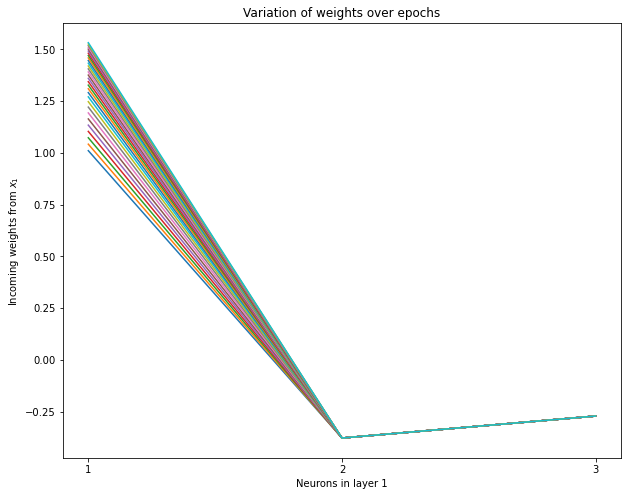

In [19]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(1, 1, figsize=(10, 8))
x_vals = range(1, NUM_UNITS + 1)

for epoch in range(0, EPOCHS):
    weights = weights_dict[epoch][0][0]
    ax.plot(x_vals, weights, label=f'epoch: {epoch + 1}')

ax.set_title('Variation of weights over epochs')
ax.set_xticks(range(1, NUM_UNITS + 1))
ax.set_xlabel('Neurons in layer 1')
ax.set_ylabel(r'Incoming weights from $x_1$');
if EPOCHS < 8:
    plt.legend();

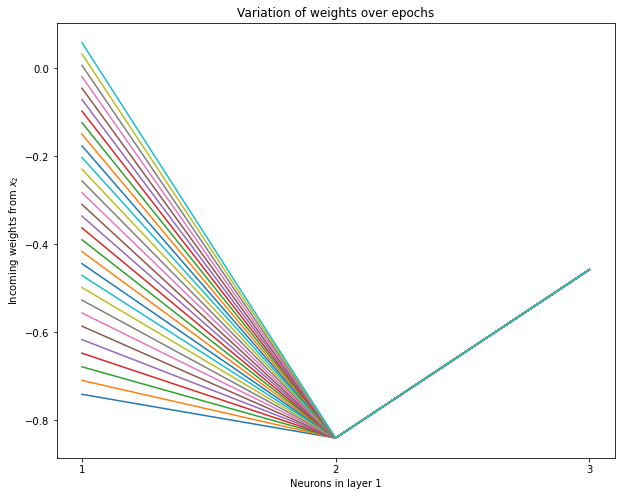

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
x_vals = range(1, NUM_UNITS + 1)

for epoch in range(0, EPOCHS):
    weights = weights_dict[epoch][0][1]
    ax.plot(x_vals, weights, label=f'epoch: {epoch + 1}')
    
ax.set_title('Variation of weights over epochs')
ax.set_xticks(range(1, NUM_UNITS + 1))
ax.set_xlabel('Neurons in layer 1')
ax.set_ylabel(r'Incoming weights from $x_2$');

if EPOCHS < 8:
    plt.legend();

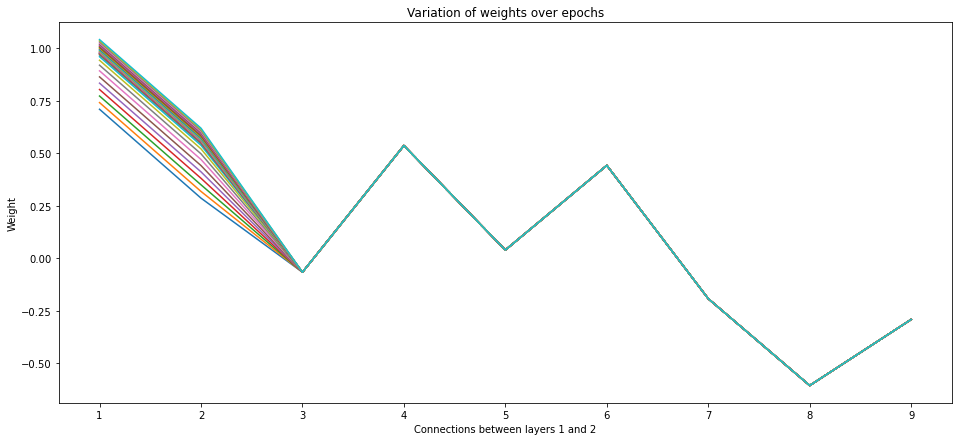

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(16, 7))
x_vals = range(1, NUM_UNITS**2 + 1)

for epoch in range(0, EPOCHS):
    weights = weights_dict[epoch][2].flatten()
    ax.plot(x_vals, weights, label=f'epoch {epoch + 1}')
    

ax.set_title('Variation of weights over epochs')

if NUM_UNITS < 6:
    ax.set_xticks(range(1, NUM_UNITS**2 + 1))

ax.set_xlabel('Connections between layers 1 and 2')
ax.set_ylabel('Weight');

if EPOCHS < 8:
    plt.legend();